In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.metrics.pairwise import cosine_distances


import os
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess

def preprocess_local_data(data_folder, file_extension='.txt'):
    """
    Preprocess local text data files in a specified directory using Doc2Vec.
    
    Parameters:
    - data_folder: str, path to the folder containing text files.
    - file_extension: str, the extension of the text files to read (default is '.txt').

    Returns:
    - hd_dist_mat: numpy.ndarray, high-dimensional distance matrix.
    - doc_vectors: pandas.DataFrame, document vectors.
    """
    # Get list of files with the specified extension
    data_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(file_extension)]

    # Read content of each file
    data = []
    for file in data_files:
        with open(file, 'r', encoding='utf-8') as f:
            content = f.read().strip()
            data.append(content)
            print("appended")

    # Prepare documents for Doc2Vec
    tagged_data = [TaggedDocument(words=simple_preprocess(doc), tags=[str(i)]) for i, doc in enumerate(data)]

    # Train Doc2Vec model
    model = Doc2Vec(vector_size=50, window=2, min_count=1, workers=4, epochs=40)
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

    # Get document vectors
    doc_vectors = [model.dv[str(i)] for i in range(len(data))]
    df_doc_vectors = pd.DataFrame(doc_vectors)

    # Standardize the document vectors
    df_doc_vectors_std = df_doc_vectors - df_doc_vectors.mean()

    # Calculate cosine distance matrix
    hd_dist_mat = cosine_distances(df_doc_vectors_std.to_numpy()) / 2

    return hd_dist_mat, df_doc_vectors_std

# Example usage
data_folder = r"C:\Users\Raphael\Projects\VAST2024\MC1\mc1_data\articles"
hd_dist_mat, df_doc_vectors_std = preprocess_local_data(data_folder)
print(hd_dist_mat)
print(df_doc_vectors_std)


appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
appended
a

c:\Users\Raphael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
c:\Users\Raphael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\Raphael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
c:\Users\Raphael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The

Final Loss: 1.2545131113978572
Optimization Time: 0.25 seconds


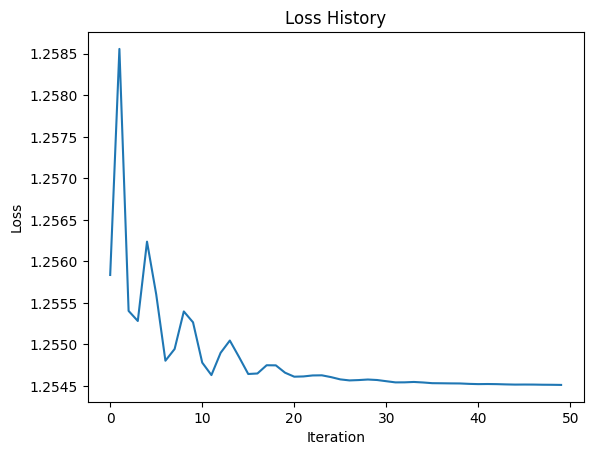

In [7]:
from sklearn.manifold import MDS


import numpy as np
import torch
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import time

def apply_custom_projection(X,y, n_iter=100, learning_rate=0.01):
    # Function to calculate the loss for the custom projection
    def torch_loss(x, t_hd_dist_mat):
        m = torch.cdist(x, x)
        return torch.mean(torch.abs(t_hd_dist_mat - torch.min(m, 1 - m)))

    N, _ = X.shape
    hd_dist_mat = distance_matrix(X, X) / 2  # Adjust as necessary for your distance metric
    t_hd_dist_mat = torch.from_numpy(hd_dist_mat)
    
    # Initialize positions on a circle
    init = torch.rand(N, 1, requires_grad=True)
    
    optimizer = torch.optim.Adam([init], lr=learning_rate)
    loss_history = []

    start = time.time()

    for i in range(n_iter):
        optimizer.zero_grad()
        loss = torch_loss(init, t_hd_dist_mat)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    print(f"Final Loss: {loss.item()}")
    print(f"Optimization Time: {time.time() - start:.2f} seconds")

    d = pd.DataFrame(data=init.detach().numpy(), columns=['ori'])
    d['x'] = d['ori'].apply(lambda x: np.cos(x * 2 * np.pi))
    d['y'] = d['ori'].apply(lambda x: np.sin(x * 2 * np.pi))
    d['target'] = y


    return d, loss_history


def apply_2d_mds(X):
    mds = MDS(n_components=2, random_state=777)
    return mds.fit_transform(X)

def apply_1d_mds(X):
    mds = MDS(n_components=1, random_state=777)
    return mds.fit_transform(X)

# Applying the projection techniques
X_mds_2d = apply_2d_mds(hd_dist_mat)
X_mds_1d = apply_1d_mds(hd_dist_mat)
X_custom, loss_history = apply_custom_projection(hd_dist_mat,y, n_iter=50, learning_rate=0.05)

# Plot the loss history
plt.plot(loss_history)
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()


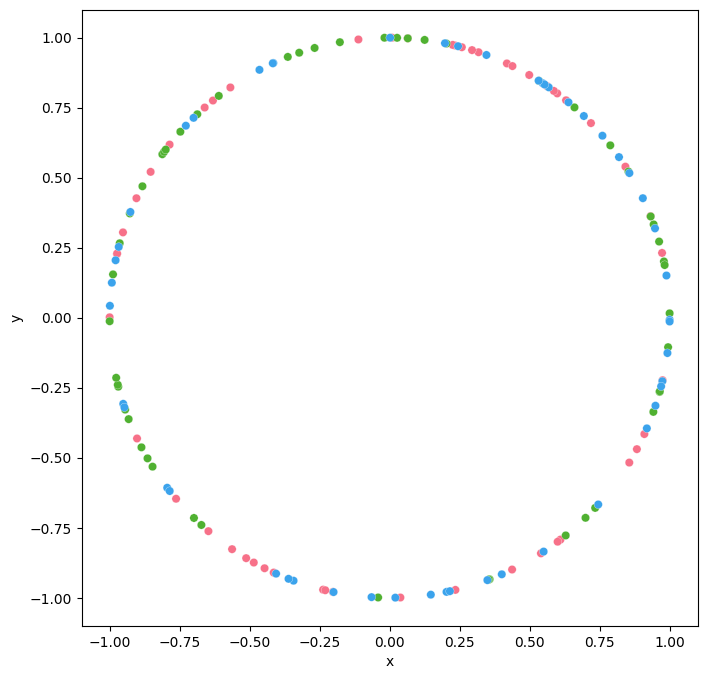

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def visualize_cPro(d,y):
    d['target'] = d['target'].astype('category')

    # Use seaborn's scatterplot for a simpler approach
    plt.figure(figsize=(8, 8))
    scatter = sns.scatterplot(data=d, x='x', y='y', hue='target', palette='husl', edgecolor='white', linewidth=0.2, legend=False)

    # Set the aspect and background color
    plt.gca().set_aspect('equal', 'box')
    plt.gca().set_facecolor('white')

    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)

    plt.show()
visualize_cPro(X_custom,y)

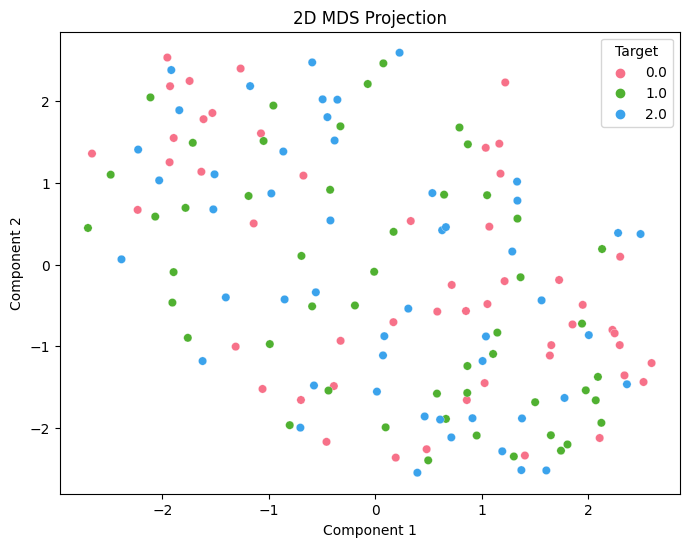

In [9]:
def visualize_2d_mds(X_2d, y):
    df_2d = pd.DataFrame(X_2d, columns=['Component 1', 'Component 2'])
    df_2d['Target'] = y
        # Determine the number of unique categories
    n_categories = df_2d['Target'].nunique()

    # Option 1: Use a categorical palette that supports a large number of categories
    palette = sns.color_palette("husl", n_categories)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_2d, x='Component 1', y='Component 2', hue='Target', palette=palette, linewidth=0.2, edgecolor='white')
    plt.title('2D MDS Projection')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend().set_title('Target')
    plt.show()

visualize_2d_mds(X_mds_2d, y)


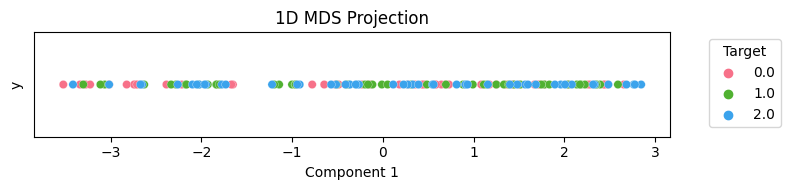

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def visualize_1d_mds(X_1d, y):
    df_1d = pd.DataFrame(X_1d, columns=['Component 1'])
    df_1d['y'] = 0  # Adding a dummy component for visualization
    df_1d['Target'] = y

    # Determine the number of unique categories
    n_categories = df_1d['Target'].nunique()

    # Option 1: Use a categorical palette that supports a large number of categories
    palette = sns.color_palette("husl", n_categories)
    
    # Option 2: Manually define a list of colors (if you know the number of categories)
    # palette = ['red', 'blue', 'green', 'orange', 'purple', ...]  # Add more colors as needed
    
    plt.figure(figsize=(8, 2))
    sns.scatterplot(data=df_1d, x='Component 1', y='y', hue='Target', palette=palette, linewidth=0.2, edgecolor='white')
    plt.title('1D MDS Projection')
    plt.xlabel('Component 1')
    plt.yticks([])
    plt.legend(title='Target', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Assuming X_mds_1d and y are already defined
visualize_1d_mds(X_mds_1d, y)


In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, euclidean_distances, pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
from scipy.stats import pearsonr
from sklearn.manifold import MDS


# Apply MDS for 2D and 1D
mds_2d = MDS(n_components=2, random_state=777)
X_2d = mds_2d.fit_transform(data_std)

mds_1d = MDS(n_components=1, random_state=777)
X_1d = mds_1d.fit_transform(data_std)

# Your custom projection
custom_projection = X_custom[['x', 'y']]

# Calculate the high-dimensional distances
hd_euclidean_dist = euclidean_distances(data_std)
hd_cosine_dist = cosine_distances(data_std)
hd_manhattan_dist = manhattan_distances(data_std)

# Calculate the low-dimensional distances for each projection
ld_euclidean_dist_2d = euclidean_distances(X_2d)
ld_euclidean_dist_1d = euclidean_distances(X_1d)
ld_euclidean_dist_custom = euclidean_distances(custom_projection)

ld_cosine_dist_2d = cosine_distances(X_2d)
ld_cosine_dist_1d = cosine_distances(X_1d)
ld_cosine_dist_custom = cosine_distances(custom_projection)

ld_manhattan_dist_2d = manhattan_distances(X_2d)
ld_manhattan_dist_1d = manhattan_distances(X_1d)
ld_manhattan_dist_custom = manhattan_distances(custom_projection)

# Define your existing functions for trustworthiness, continuity, stress, and correlation here
# Function to calculate stress
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, euclidean_distances
from sklearn.neighbors import NearestNeighbors
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
from sklearn.manifold import MDS

# Assuming data_std, df, and your projections (X_2d, X_1d, custom_projection) are already defined

# Function Definitions

def calculate_trustworthiness(X_high, X_low, n_neighbors=5, distance='euclidean'):
    if distance == 'cosine':
        X_high = cosine_distances(X_high)
        X_low = cosine_distances(X_low)
    elif distance == 'manhattan':
        X_high = manhattan_distances(X_high)
        X_low = manhattan_distances(X_low)
    
    N = X_high.shape[0]
    nn_orig = NearestNeighbors(n_neighbors=n_neighbors + 1, metric=distance).fit(X_high)
    _, indices_orig = nn_orig.kneighbors(X_high)
    
    nn_proj = NearestNeighbors(n_neighbors=N, metric=distance).fit(X_low)
    _, indices_proj = nn_proj.kneighbors(X_low)

    rank_matrix = np.full((N, n_neighbors), N)
    for i in range(N):
        for j in range(1, n_neighbors + 1):
            if indices_orig[i, j] in indices_proj[i, 1:]:
                rank_matrix[i, j - 1] = np.where(indices_proj[i] == indices_orig[i, j])[0][0]

    rank_matrix -= (n_neighbors + 1)
    trustworthiness = 1 - (2.0 / (N * n_neighbors * (2 * N - 3 * n_neighbors - 1)) *
                           np.sum(rank_matrix[rank_matrix > n_neighbors] - n_neighbors))
    return trustworthiness

def calculate_continuity(X_high, X_low, n_neighbors=5, distance='euclidean'):
    if distance == 'euclidean':
        X_high = euclidean_distances(X_high)
        X_low = euclidean_distances(X_low)
    elif distance == 'cosine':
        X_high = cosine_distances(X_high)
        X_low = cosine_distances(X_low)
    elif distance == 'manhattan':
        X_high = manhattan_distances(X_high)
        X_low = manhattan_distances(X_low)

    N = X_high.shape[0]
    nn_low = NearestNeighbors(n_neighbors=n_neighbors + 1, metric=distance).fit(X_low)
    _, indices_low = nn_low.kneighbors(X_low)

    nn_high = NearestNeighbors(n_neighbors=N, metric=distance).fit(X_high)
    _, indices_high = nn_high.kneighbors(X_high)

    rank_matrix = np.full((N, n_neighbors), N)
    for i in range(N):
        for j in range(1, n_neighbors + 1):
            if indices_low[i, j] in indices_high[i, 1:]:
                rank_matrix[i, j - 1] = np.where(indices_high[i] == indices_low[i, j])[0][0]

    rank_matrix -= (n_neighbors + 1)
    continuity = 1 - (2.0 / (N * n_neighbors * (2 * N - 3 * n_neighbors - 1)) *
                      np.sum(rank_matrix[rank_matrix > n_neighbors] - n_neighbors))
    return continuity

def calculate_stress(hd_distances, ld_distances):
    return np.sqrt(np.sum((hd_distances - ld_distances)**2) / np.sum(hd_distances**2))

def calculate_correlation(hd_distances, ld_distances):
    return pearsonr(hd_distances.flatten(), ld_distances.flatten())[0]

def calculate_trustworthiness(X_high, X_low, n_neighbors=5, distance='euclidean'):
    N = X_high.shape[0]
    
    # Depending on the distance metric, calculate the distances
    if distance == 'cosine':
        high_dist = cosine_distances(X_high)
        low_dist = cosine_distances(X_low)
    elif distance == 'manhattan':
        high_dist = manhattan_distances(X_high)
        low_dist = manhattan_distances(X_low)
    else:  # Euclidean
        high_dist = euclidean_distances(X_high)
        low_dist = euclidean_distances(X_low)

    # Compute nearest neighbors in the original high-dimensional space
    nn_orig = NearestNeighbors(n_neighbors=n_neighbors + 1, metric=distance).fit(X_high)
    _, indices_orig = nn_orig.kneighbors(X_high)
    
    # Compute nearest neighbors in the low-dimensional space
    nn_proj = NearestNeighbors(n_neighbors=N, metric=distance).fit(X_low)
    _, indices_proj = nn_proj.kneighbors(X_low)

    # Calculate the rank matrix
    rank_matrix = np.full((N, n_neighbors), N)
    for i in range(N):
        for j in range(1, n_neighbors + 1):
            high_neighbor = indices_orig[i, j]
            if high_neighbor in indices_proj[i]:
                low_neighbor_rank = np.where(indices_proj[i] == high_neighbor)[0][0]
                rank_matrix[i, j - 1] = low_neighbor_rank

    # Subtract (n_neighbors + 1) from each element in the rank matrix
    rank_matrix -= (n_neighbors + 1)

    # Calculate the trustworthiness
    trustworthiness = 1 - (2.0 / (N * n_neighbors * (2 * N - 3 * n_neighbors - 1)) * 
                           np.sum(rank_matrix[rank_matrix > 0]))
    return trustworthiness

# Assuming 'data_std', 'X_transformed', 'd_1d', and 'custom_projection' are defined
# Calculating distances for Euclidean, Cosine, and Manhattan
# Function to calculate average distance (as a proxy for compactness)
def calculate_average_distance(X, distance='euclidean'):
    if distance == 'cosine':
        dist = cosine_distances(X)
    elif distance == 'manhattan':
        dist = manhattan_distances(X)
    else:  # Euclidean
        dist = euclidean_distances(X)
    return np.mean(dist)

# Calculate average distance for each projection and distance metric
avg_dist_euclidean_2d = calculate_average_distance(X_2d, distance='euclidean')
avg_dist_euclidean_1d = calculate_average_distance(X_1d, distance='euclidean')
avg_dist_euclidean_custom = calculate_average_distance(custom_projection, distance='euclidean')

avg_dist_cosine_2d = calculate_average_distance(X_2d, distance='cosine')
avg_dist_cosine_1d = calculate_average_distance(X_1d, distance='cosine')
avg_dist_cosine_custom = calculate_average_distance(custom_projection, distance='cosine')

avg_dist_manhattan_2d = calculate_average_distance(X_2d, distance='manhattan')
avg_dist_manhattan_1d = calculate_average_distance(X_1d, distance='manhattan')
avg_dist_manhattan_custom = calculate_average_distance(custom_projection, distance='manhattan')

# Euclidean distances
hd_euclidean_dist = euclidean_distances(data_std)
ld_euclidean_dist_2d = euclidean_distances(X_2d)
ld_euclidean_dist_1d = euclidean_distances(X_1d)
ld_euclidean_dist_custom = euclidean_distances(custom_projection)

# Cosine distances
hd_cosine_dist = cosine_distances(data_std)
ld_cosine_dist_2d = cosine_distances(X_2d)
ld_cosine_dist_1d = cosine_distances(X_1d)
ld_cosine_dist_custom = cosine_distances(custom_projection)

# Manhattan distances
hd_manhattan_dist = manhattan_distances(data_std)
ld_manhattan_dist_2d = manhattan_distances(X_2d)
ld_manhattan_dist_1d = manhattan_distances(X_1d)
ld_manhattan_dist_custom = manhattan_distances(custom_projection)

# Stress and correlation calculations for each metric
# Euclidean
stress_euclidean_2d = calculate_stress(hd_euclidean_dist, ld_euclidean_dist_2d)
stress_euclidean_1d = calculate_stress(hd_euclidean_dist, ld_euclidean_dist_1d)
stress_euclidean_custom = calculate_stress(hd_euclidean_dist, ld_euclidean_dist_custom)
correlation_euclidean_2d = calculate_correlation(hd_euclidean_dist, ld_euclidean_dist_2d)
correlation_euclidean_1d = calculate_correlation(hd_euclidean_dist, ld_euclidean_dist_1d)
correlation_euclidean_custom = calculate_correlation(hd_euclidean_dist, ld_euclidean_dist_custom)

# Cosine
stress_cosine_2d = calculate_stress(hd_cosine_dist, ld_cosine_dist_2d)
stress_cosine_1d = calculate_stress(hd_cosine_dist, ld_cosine_dist_1d)
stress_cosine_custom = calculate_stress(hd_cosine_dist, ld_cosine_dist_custom)
correlation_cosine_2d = calculate_correlation(hd_cosine_dist, ld_cosine_dist_2d)
correlation_cosine_1d = calculate_correlation(hd_cosine_dist, ld_cosine_dist_1d)
correlation_cosine_custom = calculate_correlation(hd_cosine_dist, ld_cosine_dist_custom)

# Manhattan
stress_manhattan_2d = calculate_stress(hd_manhattan_dist, ld_manhattan_dist_2d)
stress_manhattan_1d = calculate_stress(hd_manhattan_dist, ld_manhattan_dist_1d)
stress_manhattan_custom = calculate_stress(hd_manhattan_dist, ld_manhattan_dist_custom)
correlation_manhattan_2d = calculate_correlation(hd_manhattan_dist, ld_manhattan_dist_2d)
correlation_manhattan_1d = calculate_correlation(hd_manhattan_dist, ld_manhattan_dist_1d)
correlation_manhattan_custom = calculate_correlation(hd_manhattan_dist, ld_manhattan_dist_custom)

# Silhouette scores for each metric
silhouette_euclidean_2d = silhouette_score(X_2d, y)
silhouette_euclidean_1d = silhouette_score(X_1d, y)
silhouette_euclidean_custom = silhouette_score(custom_projection, y)

silhouette_cosine_2d = silhouette_score(X_2d, y, metric='cosine')
silhouette_cosine_1d = silhouette_score(X_1d, y, metric='cosine')
silhouette_cosine_custom = silhouette_score(custom_projection,y, metric='cosine')

silhouette_manhattan_2d = silhouette_score(X_2d,y, metric='manhattan')
silhouette_manhattan_1d = silhouette_score(X_1d, y, metric='manhattan')
silhouette_manhattan_custom = silhouette_score(custom_projection, y, metric='manhattan')


# Euclidean
trust_euclidean_2d = calculate_trustworthiness(data_std, X_2d, distance='euclidean')
trust_euclidean_1d = calculate_trustworthiness(data_std, X_1d, distance='euclidean')
trust_euclidean_custom = calculate_trustworthiness(data_std, custom_projection, distance='euclidean')

# Cosine
trust_cosine_2d = calculate_trustworthiness(data_std, X_2d, distance='cosine')
trust_cosine_1d = calculate_trustworthiness(data_std, X_1d, distance='cosine')
trust_cosine_custom = calculate_trustworthiness(data_std, custom_projection, distance='cosine')

# Manhattan
trust_manhattan_2d = calculate_trustworthiness(data_std, X_2d, distance='manhattan')
trust_manhattan_1d = calculate_trustworthiness(data_std, X_1d, distance='manhattan')
trust_manhattan_custom = calculate_trustworthiness(data_std, custom_projection, distance='manhattan')
# Your code to display or analyze the calculated metrics goes here

print("2D MDS Metrics:")
print(f"  Euclidean - Stress: {stress_euclidean_2d}, Correlation: {correlation_euclidean_2d}, Silhouette: {silhouette_euclidean_2d}, Trustworthiness: {trust_euclidean_2d}, Avg Dist: {avg_dist_euclidean_2d}")
print(f"  Cosine - Stress: {stress_cosine_2d}, Correlation: {correlation_cosine_2d}, Silhouette: {silhouette_cosine_2d}, Trustworthiness: {trust_cosine_2d}, Avg Dist: {avg_dist_cosine_2d}")
print(f"  Manhattan - Stress: {stress_manhattan_2d}, Correlation: {correlation_manhattan_2d}, Silhouette: {silhouette_manhattan_2d}, Trustworthiness: {trust_manhattan_2d}, Avg Dist: {avg_dist_manhattan_2d}")
print("\n")

print("1D MDS Metrics:")
print(f"  Euclidean - Stress: {stress_euclidean_1d}, Correlation: {correlation_euclidean_1d}, Silhouette: {silhouette_euclidean_1d}, Trustworthiness: {trust_euclidean_1d}, Avg Dist: {avg_dist_euclidean_1d}")
print(f"  Cosine - Stress: {stress_cosine_1d}, Correlation: {correlation_cosine_1d}, Silhouette: {silhouette_cosine_1d}, Trustworthiness: {trust_cosine_1d}, Avg Dist: {avg_dist_cosine_1d}")
print(f"  Manhattan - Stress: {stress_manhattan_1d}, Correlation: {correlation_manhattan_1d}, Silhouette: {silhouette_manhattan_1d}, Trustworthiness: {trust_manhattan_1d}, Avg Dist: {avg_dist_manhattan_1d}")
print("\n")

print("Custom Projection Metrics:")
print(f"  Euclidean - Stress: {stress_euclidean_custom}, Correlation: {correlation_euclidean_custom}, Silhouette: {silhouette_euclidean_custom}, Trustworthiness: {trust_euclidean_custom}, Avg Dist: {avg_dist_euclidean_custom}")
print(f"  Cosine - Stress: {stress_cosine_custom}, Correlation: {correlation_cosine_custom}, Silhouette: {silhouette_cosine_custom}, Trustworthiness: {trust_cosine_custom}, Avg Dist: {avg_dist_cosine_custom}")
print(f"  Manhattan - Stress: {stress_manhattan_custom}, Correlation: {correlation_manhattan_custom}, Silhouette: {silhouette_manhattan_custom}, Trustworthiness: {trust_manhattan_custom}, Avg Dist: {avg_dist_manhattan_custom}")
print("\n")


c:\Users\Raphael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\Raphael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


ValueError: operands could not be broadcast together with shapes (150,150) (338,338) 